### NeuroDOT_py Preprocessing Script
 This script includes details on the NeuroDOT Preprocessing pipeline. <br>
 A file of sample data is already designated below, but you can use the "loadmat_py function to load your own optical data in 'mat' file format. <br>
 In order to load the sample file, change the path below in the "sys.path.insert" lines to the folder under which you have NeuroDOT_py installed.

In [1]:
# General imports
import sys
import math
import copy
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import scipy.interpolate
import numpy.matlib as mlb
import numpy.matlib as nm
import functools as ft
import os

from math import trunc
from pickle import NONE
from numpy import float64, matrix
from numpy.lib.shape_base import expand_dims
from matplotlib.pyplot import colorbar, colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'neuro_dot'))
from Visualizations import viz
from Spatial_Transforms import sx4m
from Temporal_Transforms import tx4m
from Light_Modeling import lmdl
from File_IO import io
from Analysis import anlys
from Matlab_Equivalent_Functions import matlab


In [2]:
## Load data
participant_data = 'NeuroDOT_Data_Sample_CCW1.mat' # Name of your data file, or one of the NeuroDOT data samples in the 'Data' folder
data_path = os.path.join(os.path.dirname(sys.path[0]),'Data',participant_data)
data = io.loadmat(data_path)['data']     
__info = io.loadmat(data_path)['info']             
flags = io.loadmat(data_path)['flags']
E = None
MNI = None
params = {'bthresh':0.01,'det':1, 'highpass':1, 'lowpass1':1, 'ssr':1, 'lowpass2':1, 'DoGVTD':1, 'resample': 1, 'omega_hp': 0.02, 'omega_lp1': 1, 'omega_lp2': 0.5,'freqout': 1, 'rstol': 1e-5 ,'DQC_ONLY': 0, 'omega_resample': 1} #flags. in dot_processing preprocessing section add to params list

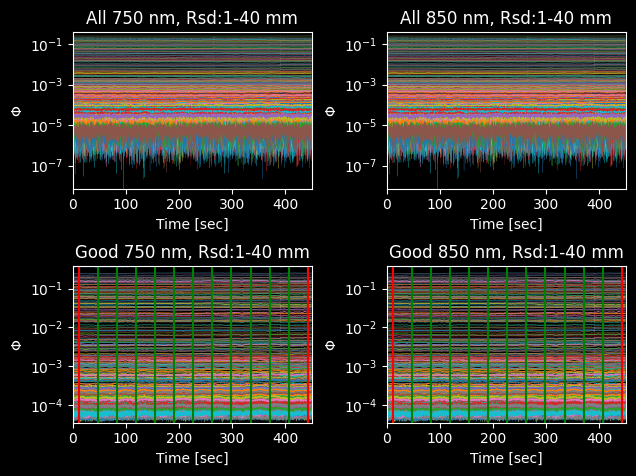

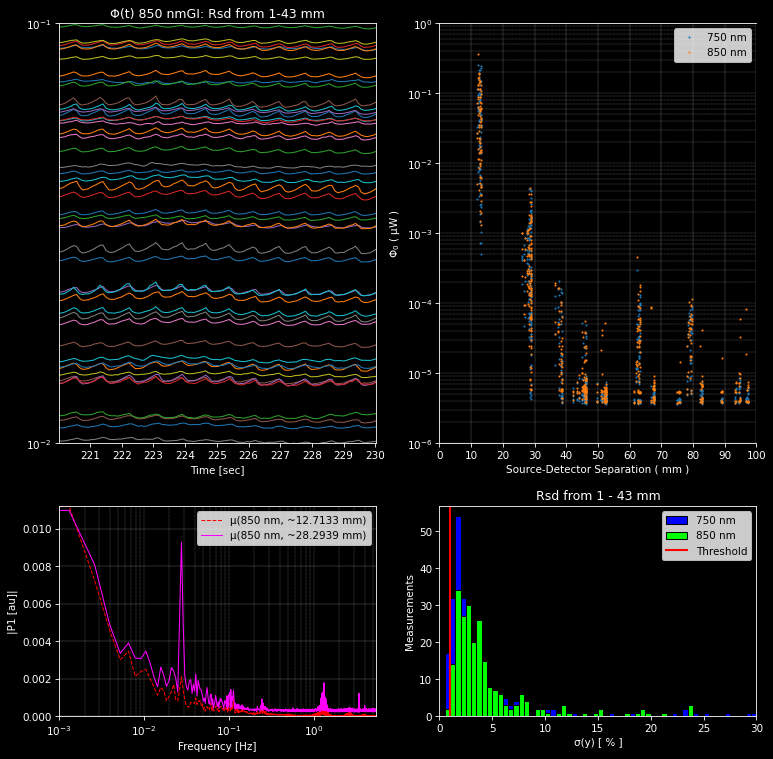

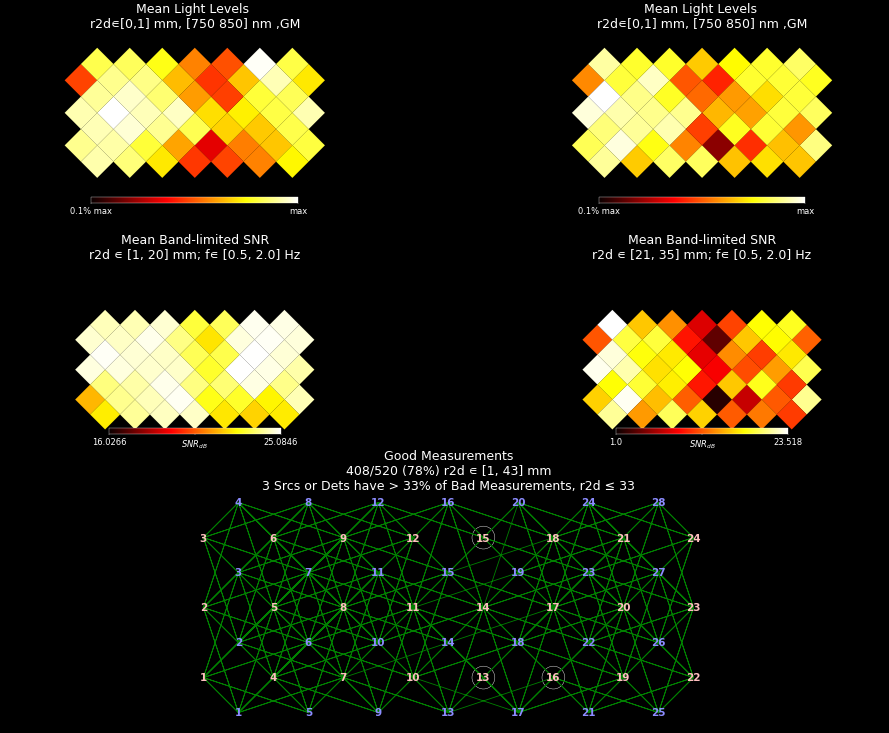

In [3]:
params_timetraces = copy.deepcopy(params)
params_datametrics_2 = copy.deepcopy(params)
viz.Plot_RawData_Time_Traces_Overview(data,__info,params_timetraces)     # Time traces
viz.Plot_RawData_Metrics_II_DQC(data,__info,params_datametrics_2)        # Spectrum, falloff, and good signal metric
__info_out = viz.Plot_RawData_Cap_DQC(data,__info,params)                # Cap-relevant views

In [4]:
## Logmean Light Levels
lmdata = tx4m.logmean(data)[0]

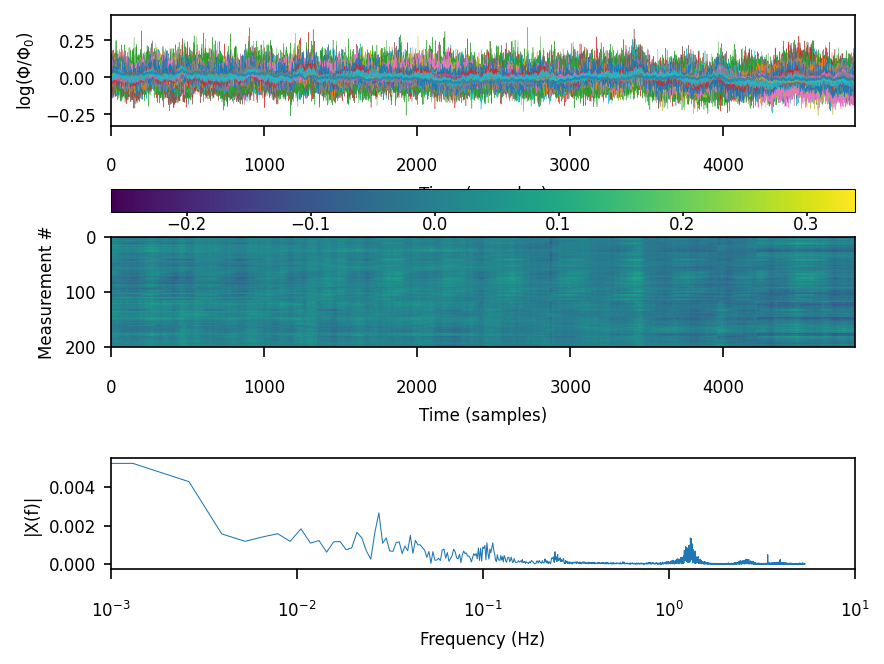

In [5]:
## Detect Noisy Channels
info = anlys.FindGoodMeas(lmdata, __info, 0.01) 

# Example visualization
keep = np.logical_and(np.logical_and(np.where(info['pairs']['WL'] == 2,1,0), np.where(info['pairs']['r2d'] < 40,1,0)), info['MEAS']['GI']) # measurements to include

fig = plt.figure(dpi = 150)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lmdata[keep,:]), linewidth = 0.2) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(lmdata[keep,:]),1.25*np.amax(abs(lmdata[keep,:]))])
ax1.set_xlim([0, len(lmdata[keep][1])])

im2 = ax2.imshow(lmdata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(lmdata[keep,:]),1), (len(np.mean(np.transpose(lmdata[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%",  
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5) # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)

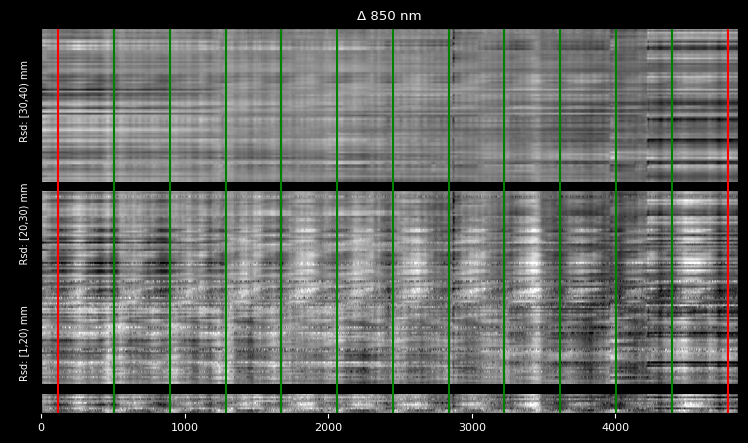

In [6]:
## Show nn1, nn2, nn3 (plots)
viz.nlrGrayPlots_220324(lmdata,info)

(-0.13175501337557569, 0.2002219987153482)

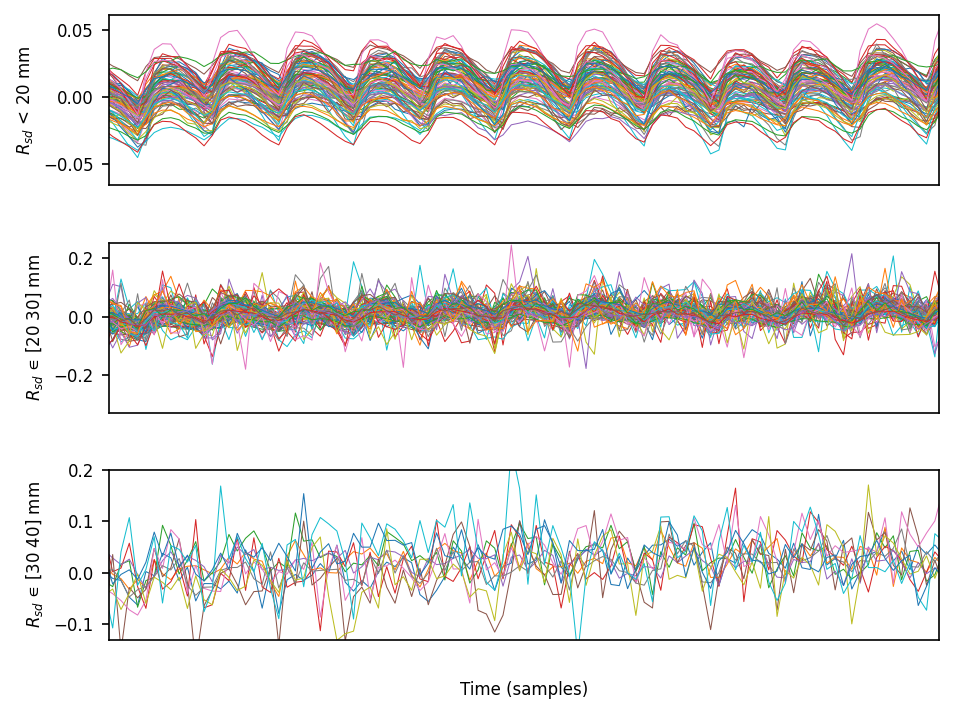

In [7]:
# Visualize Data after Logmean and Cleaning Measurements at different S-D distances
keepd1=np.logical_and(np.logical_and(info['MEAS']['GI'], np.where(info['pairs']['r2d']<20,1,0)), np.where(info['pairs']['WL']==2,1,0))
keepd2=np.logical_and(np.logical_and(np.logical_and(info['MEAS']['GI'], np.where(info['pairs']['r2d']>=20,1,0)), np.where(info['pairs']['r2d']<30,1,0)), np.where(info['pairs']['WL']==2,1,0))
keepd3=np.logical_and(np.logical_and(np.logical_and(info['MEAS']['GI'], np.where(info['pairs']['r2d']>=30,1,0)), np.where(info['pairs']['r2d']<40,1,0)), np.where(info['pairs']['WL']==2,1,0))

fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lmdata[keepd1,:]), linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$ < 20 mm')
ax1.set_xlim([np.shape(lmdata[keepd1,:])[1]/2,(np.shape(lmdata[keepd1,:])[1]/2 +100)])
ax1.set_ylim([np.amin(lmdata[keepd1,:])*0.5, np.amax(lmdata[keepd1,:])*0.5])
ax2.plot(np.transpose(lmdata[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([np.shape(lmdata[keepd2,:])[1]/2,(np.shape(lmdata[keepd2,:])[1]/2 +100)])
ax2.set_ylim([np.amin(lmdata[keepd2,:])*1.25, np.amax(lmdata[keepd2,:])*0.75])

ax3.plot(np.transpose(lmdata[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([np.shape(lmdata[keepd3,:])[1]/2,(np.shape(lmdata[keepd3,:])[1]/2 +100)])
ax3.set_ylim([np.amin(lmdata[keepd1,:]), np.amax(lmdata[keepd3,:])*0.75])

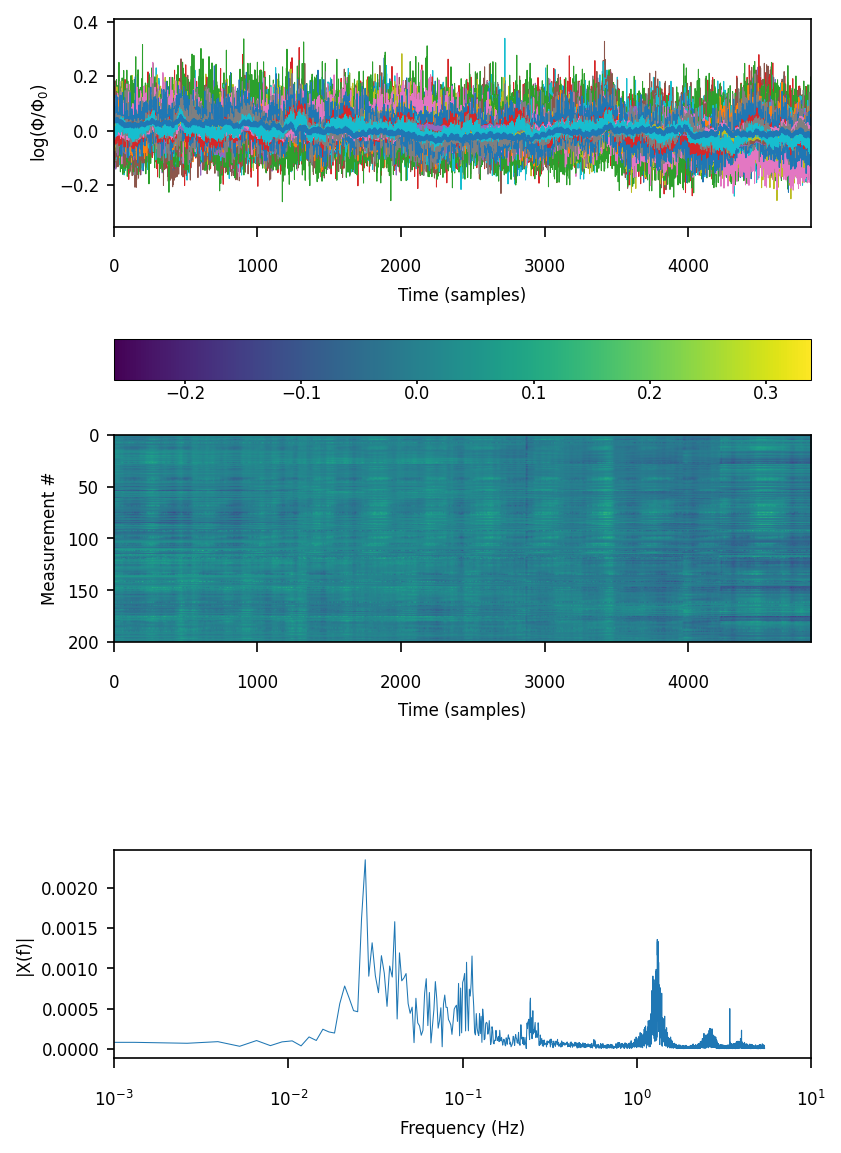

In [8]:
## Detrend and High-pass Filter the Data
ddata = tx4m.detrend_tts(lmdata)

# High Pass Filter
hpdata = tx4m.highpass(ddata, 0.02, info['system']['framerate'])
# hpdata = highpass(ddata, 0.05, info['system']['framerate']); % problematic cutoff frequency example

fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lmdata[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(hpdata[keep,:]),1.25*np.amax(abs(hpdata[keep,:]))])
ax1.set_xlim([0, len(hpdata[keep][1])])

im2 = ax2.imshow(lmdata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(hpdata[keep,:]),1), (len(np.mean(np.transpose(hpdata[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%",  
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)

(-0.22561313875416455, 0.1850101648752506)

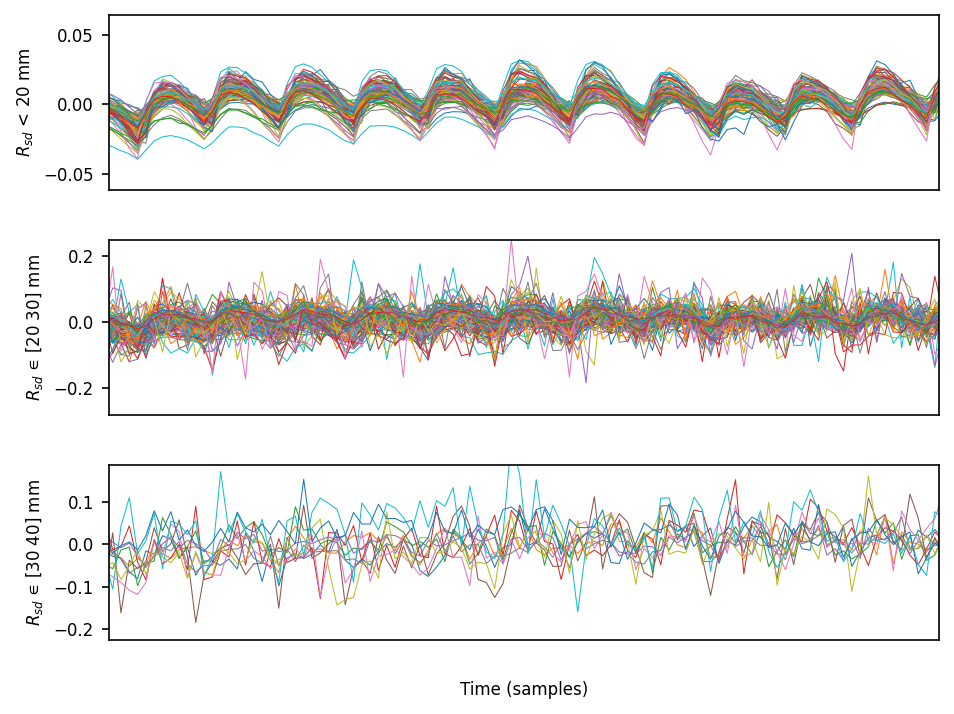

In [9]:
# Visualize Data after High-Pass Filtering at different S-D distances
fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(hpdata[keepd1,:]), linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$ < 20 mm')
ax1.set_xlim([np.shape(hpdata[keepd1,:])[1]/2,(np.shape(hpdata[keepd1,:])[1]/2 +100)])
ax1.set_ylim([np.amin(hpdata[keepd1,:])*0.5, np.amax(hpdata[keepd1,:])*0.75])

ax2.plot(np.transpose(hpdata[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([np.shape(hpdata[keepd2,:])[1]/2,(np.shape(hpdata[keepd2,:])[1]/2 +100)])
ax2.set_ylim([np.amin(hpdata[keepd2,:]), np.amax(hpdata[keepd2,:])*0.75])


ax3.plot(np.transpose(hpdata[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([np.shape(hpdata[keepd3,:])[1]/2,(np.shape(hpdata[keepd3,:])[1]/2 +100)])
ax3.set_ylim([np.amin(hpdata[keepd3,:]), np.amax(hpdata[keepd3,:])*0.75])

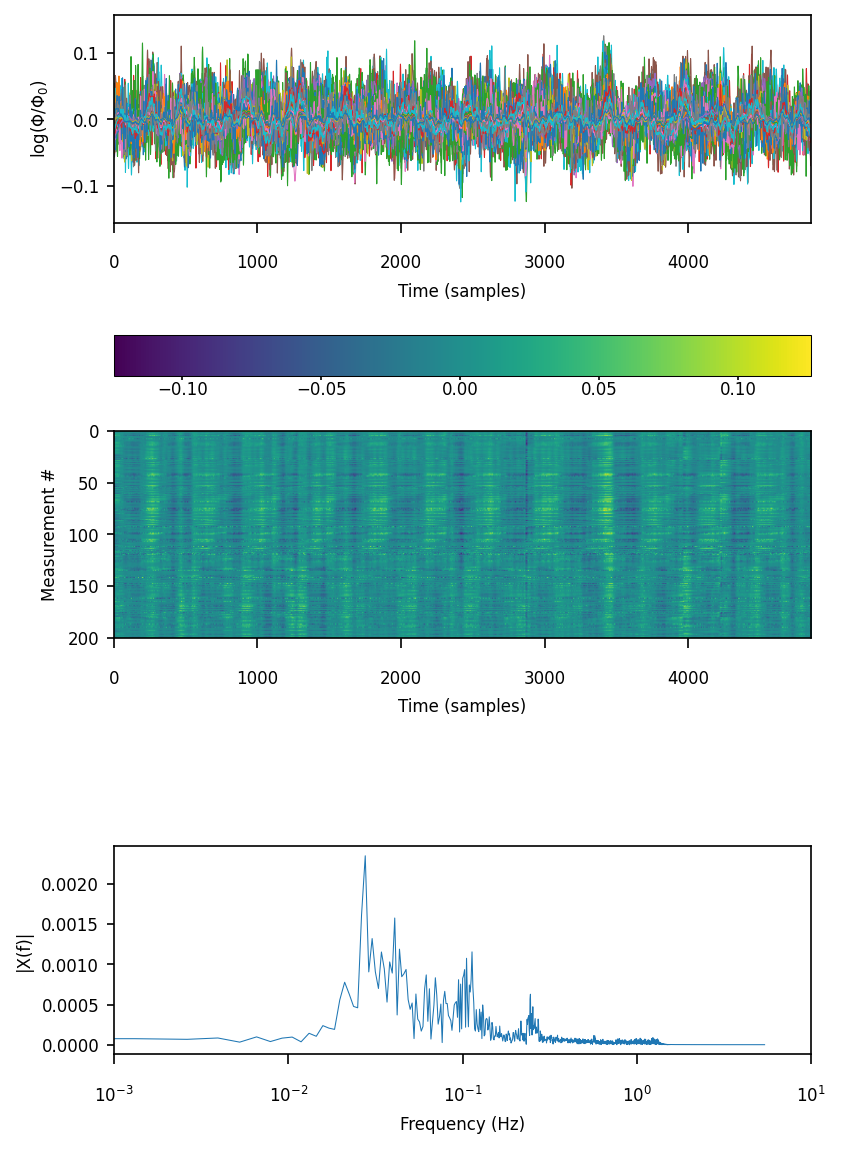

In [10]:
## Low Pass Filter 1
lp1data = tx4m.lowpass(hpdata, 1, info['system']['framerate'])

fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lp1data[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(lp1data[keep,:]),1.25*np.amax(abs(lp1data[keep,:]))])
ax1.set_xlim([0, len(lp1data[keep][1])])

im2 = ax2.imshow(lp1data[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(lp1data[keep,:]),1), (len(np.mean(np.transpose(lp1data[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%",  
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)

(-0.09892905519627998, 0.09467798843055644)

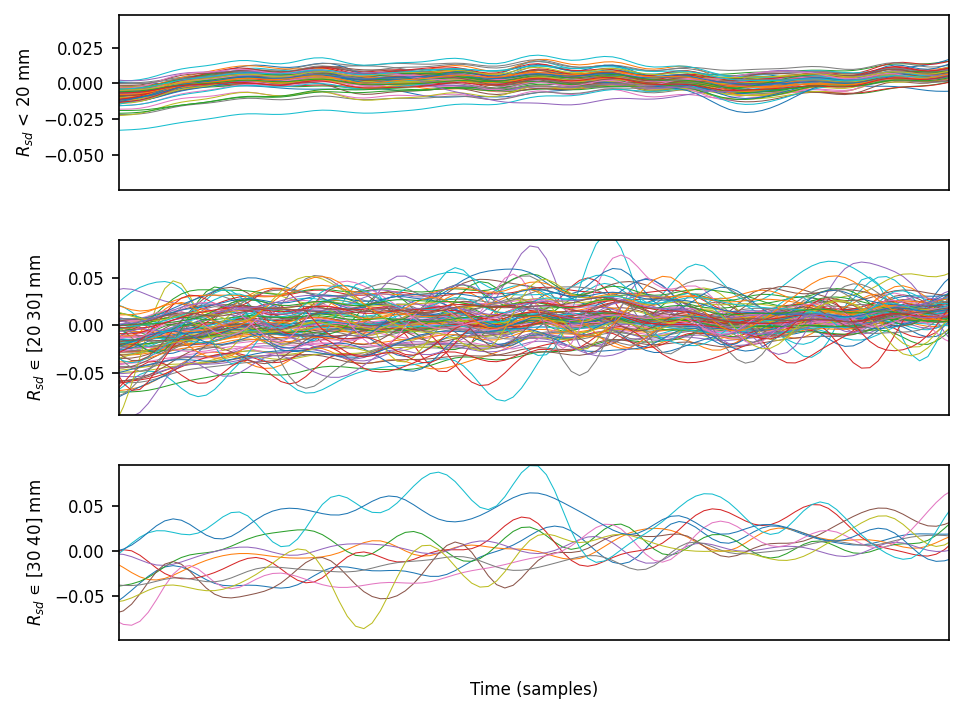

In [11]:
# Visualize Data after Low-Pass Filtering at different S-D distances
fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lp1data[keepd1,:]), linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$ < 20 mm')
ax1.set_xlim([np.shape(lp1data[keepd1,:])[1]/2,(np.shape(lp1data[keepd1,:])[1]/2 +100)])
ax1.set_ylim([np.amin(lp1data[keepd1,:])*0.8, np.amax(lp1data[keepd1,:])*0.75])


ax2.plot(np.transpose(lp1data[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([np.shape(lp1data[keepd2,:])[1]/2,(np.shape(lp1data[keepd2,:])[1]/2 +100)])
ax2.set_ylim([np.amin(lp1data[keepd2,:])*0.75, np.amax(lp1data[keepd2,:])*0.75])

ax3.plot(np.transpose(lp1data[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([np.shape(lp1data[keepd3,:])[1]/2,(np.shape(lp1data[keepd3,:])[1]/2 +100)])
ax3.set_ylim([np.amin(lp1data[keepd3,:])*0.8, np.amax(lp1data[keepd3,:])*0.75])

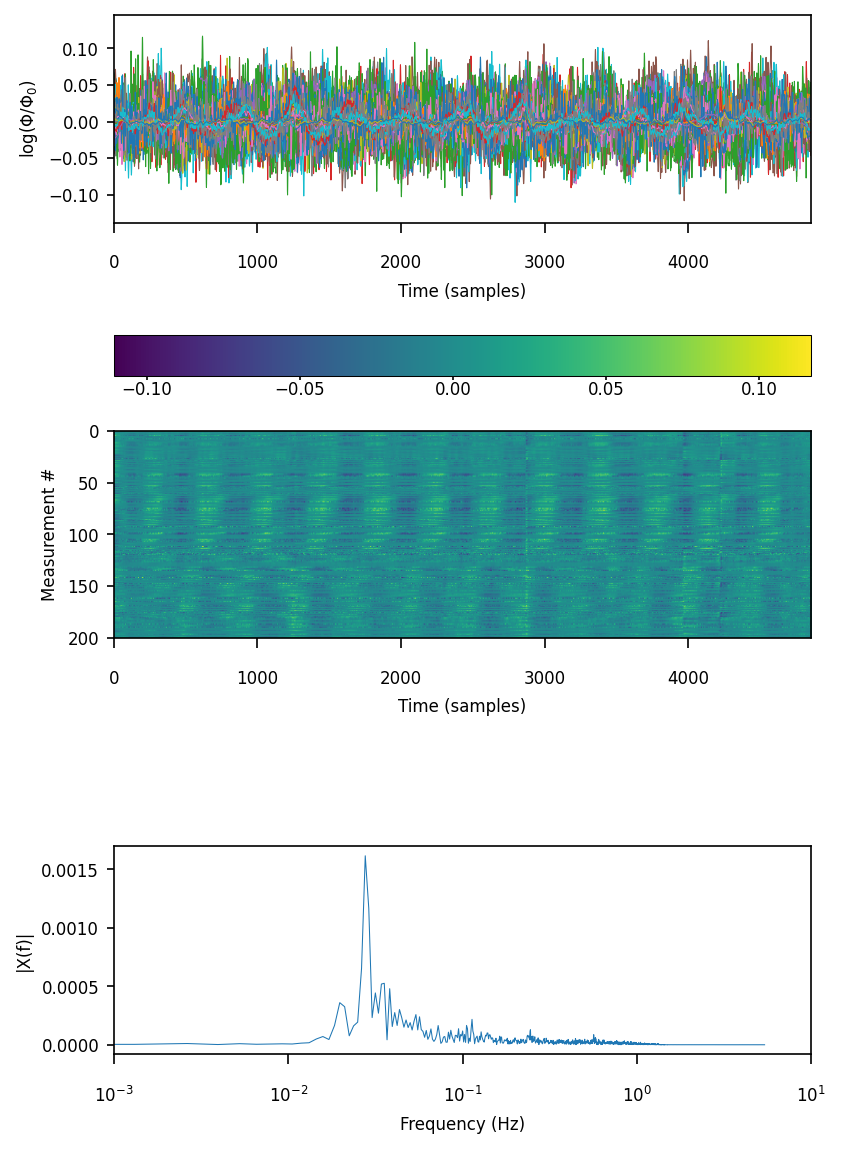

In [12]:
## Superficial Signal Regression
hem = tx4m.gethem(lp1data, info)
SSRdata, _ = tx4m.regcorr(lp1data, info, hem)

fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(SSRdata[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(SSRdata[keep,:]),1.25*np.amax(abs(SSRdata[keep,:]))])
ax1.set_xlim([0, len(SSRdata[keep][1])])

im2 = ax2.imshow(SSRdata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(SSRdata[keep,:]),1), (len(np.mean(np.transpose(SSRdata[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%", 
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)

(0.001, 10)

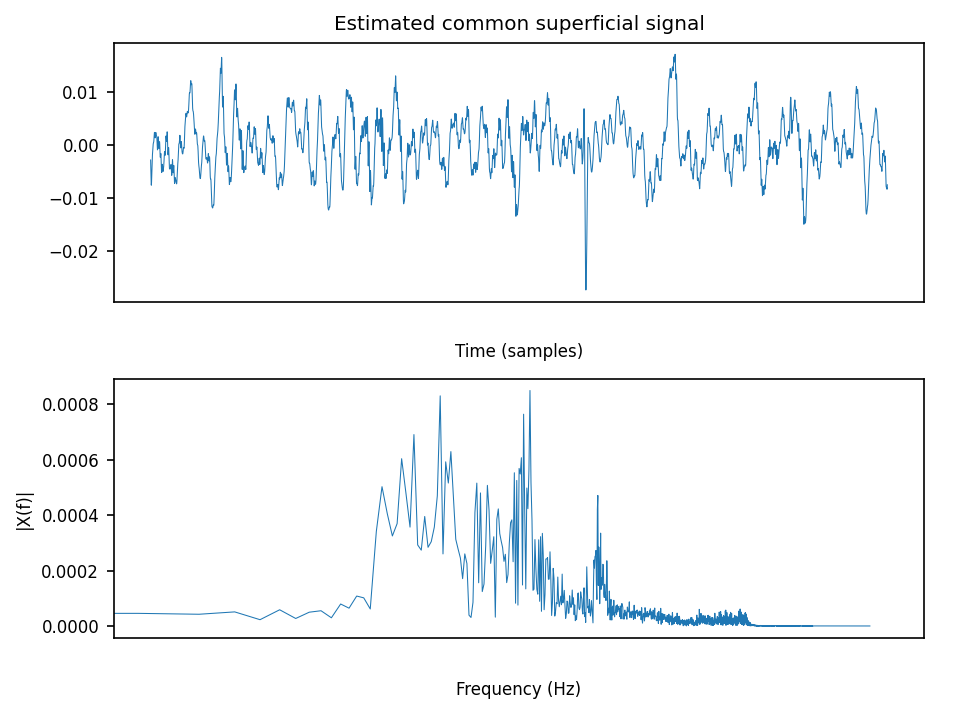

In [13]:
# Visualize Superficial Signal Time Trace and Power Spectrum
fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(2,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])

ax1.plot(hem[1,:], linewidth = 0.5)
ax1.set_title('Estimated common superficial signal')
ax1.set_xlabel('Time (samples)')

arr1 = hem[1,:]
arr = np.reshape(arr1, (1,np.size(arr1)))
ftdomain,ftmag,_,_ = tx4m.fft_tts(arr,info['system']['framerate']) 
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax2.semilogx(ftdomain,ftmag, linewidth = 0.5)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('|X(f)|') # plot vs. log frequency
ax2.set_xlim([1e-3, 10])

(2428.5, 3428.5)

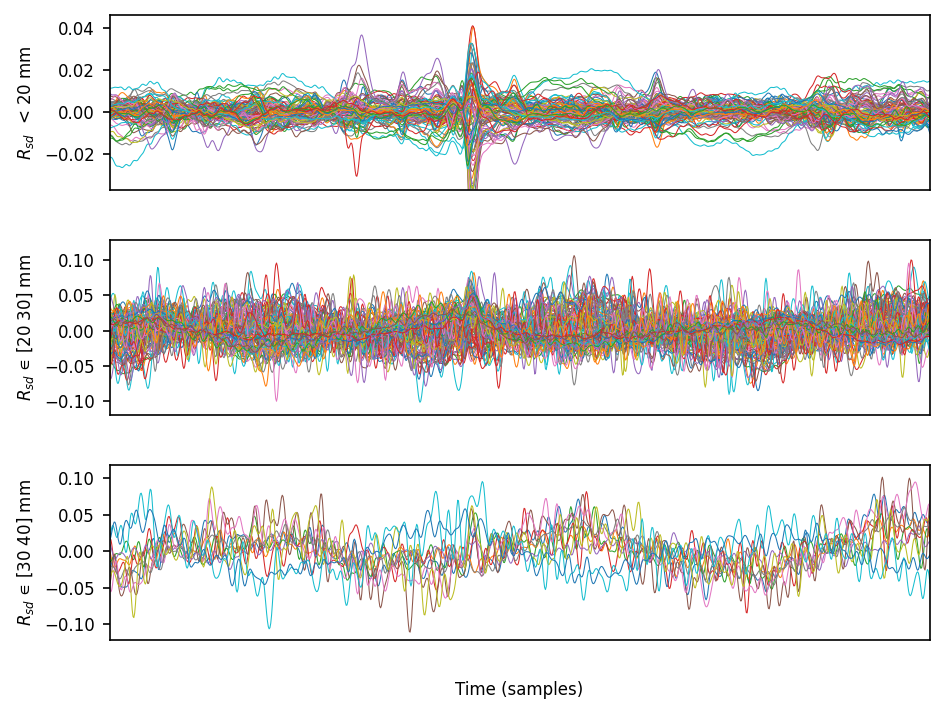

In [14]:
# Visualize Data after Superficial Signal Regression at different S-D distances
fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(SSRdata[keepd1,:]), linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$  < 20 mm')
ax1.set_xlim([np.shape(SSRdata[keepd1,:])[1]/2,(np.shape(SSRdata[keepd1,:])[1]/2 +1000)])
ax1.set_ylim([np.amin(SSRdata[keepd1,:])*0.5, np.amax(SSRdata[keepd1,:])*0.75])

ax2.plot(np.transpose(SSRdata[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([np.shape(SSRdata[keepd2,:])[1]/2,(np.shape(SSRdata[keepd2,:])[1]/2 +1000)])

ax3.plot(np.transpose(SSRdata[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([np.shape(SSRdata[keepd3,:])[1]/2,(np.shape(SSRdata[keepd3,:])[1]/2 +1000)])

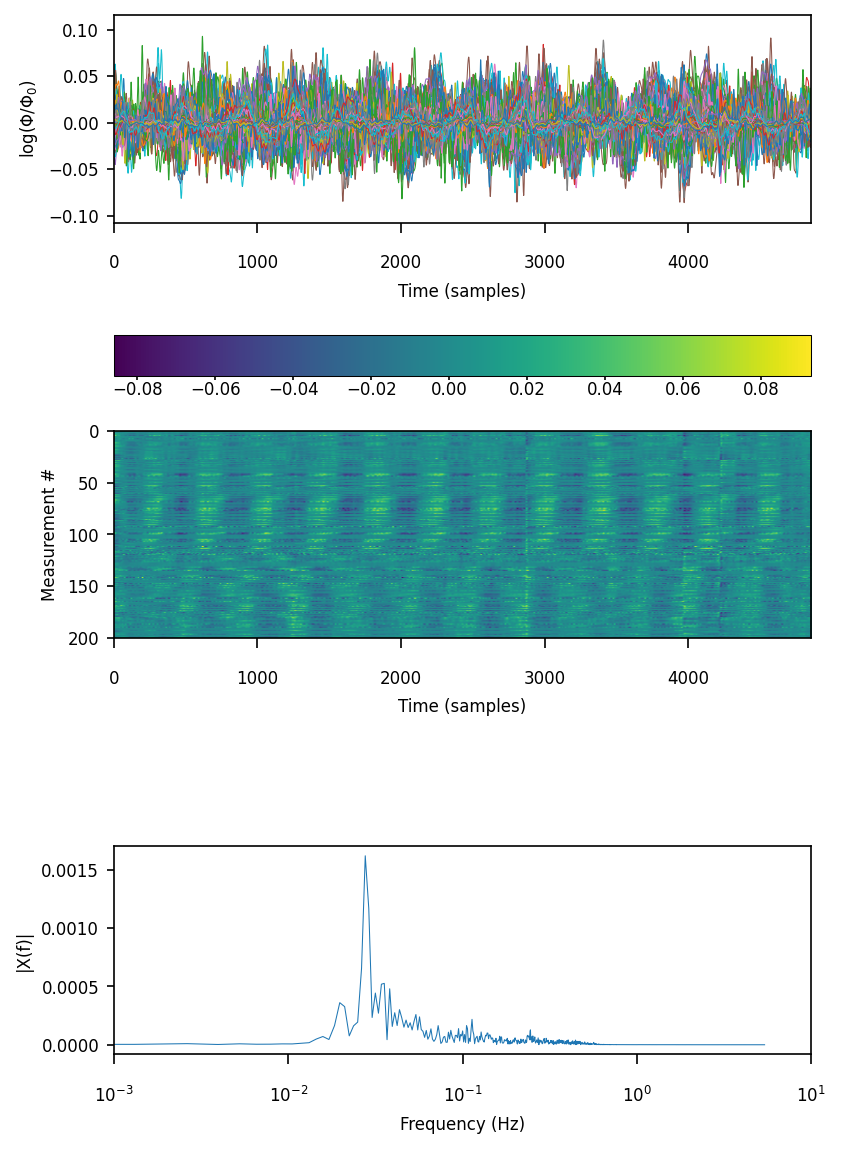

In [15]:
## Low Pass Filter 2
lp2data = tx4m.lowpass(SSRdata, 0.5, info['system']['framerate'])

# Generate 3 subplots
fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(lp2data[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(lp2data[keep,:]),1.25*np.amax(abs(lp2data[keep,:]))])
ax1.set_xlim([0, len(lp2data[keep][1])])

im2 = ax2.imshow(lp2data[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(lp2data[keep,:]),1), (len(np.mean(np.transpose(lp2data[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%", 
                        height="20%",
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)


2381 25702


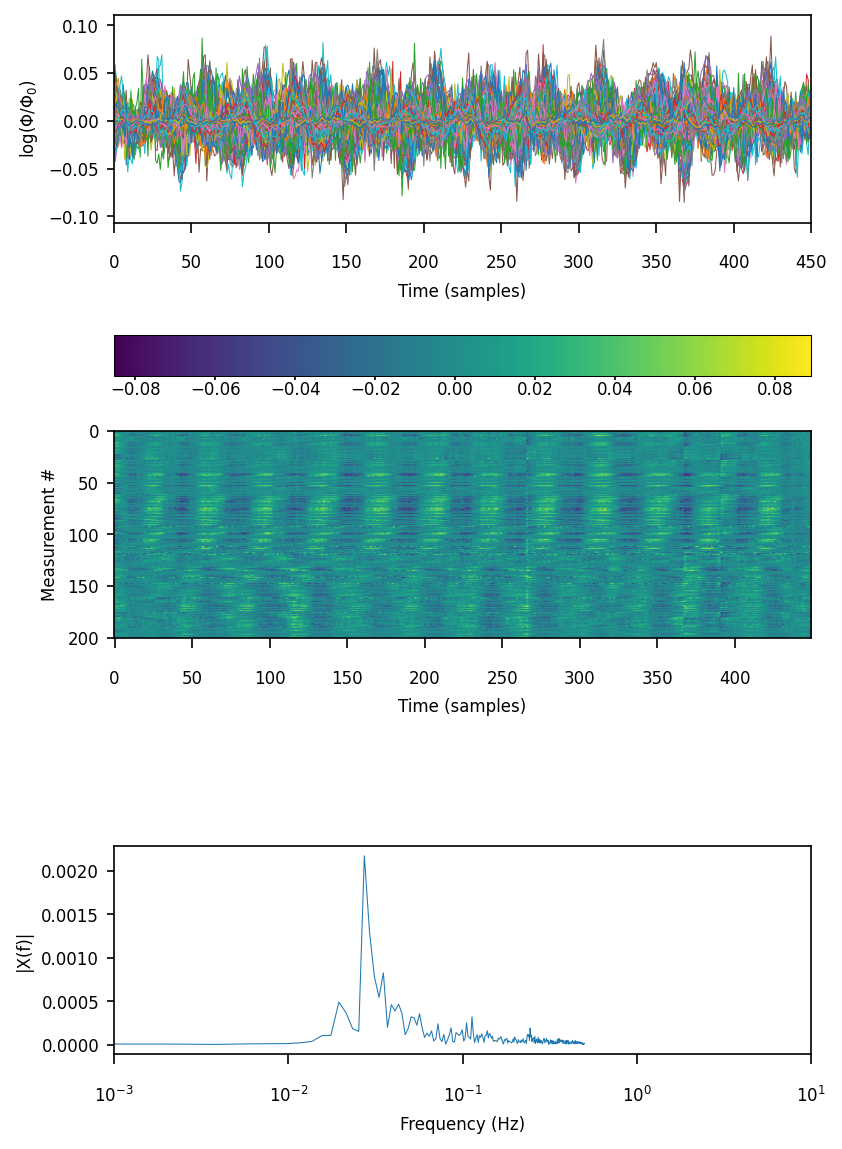

In [16]:
##Resampling
rdata, info = tx4m.resample_tts(lp2data, info, params['omega_resample'], params['rstol'])

# Generate 3 subplots
fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(rdata[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(rdata[keep,:]),1.25*np.amax(abs(rdata[keep,:]))])
ax1.set_xlim([0, len(rdata[keep][1])])

im2 = ax2.imshow(rdata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(rdata[keep,:]),1), (len(np.mean(np.transpose(rdata[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%",  
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)



(225.0, 325.0)

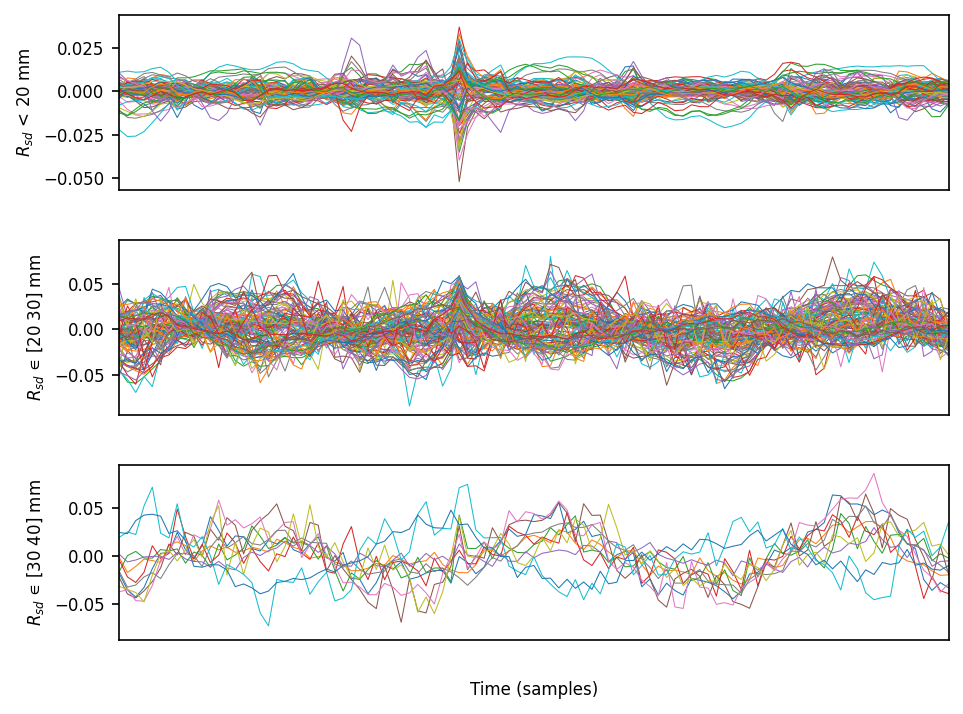

In [17]:
# Visualize Data after Resampling at different S-D distances
fig = plt.figure(dpi = 150, tight_layout = True, facecolor= 'white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(rdata[keepd1,:]),linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$ < 20 mm')
ax1.set_xlim([np.shape(rdata[keepd1,:])[1]/2,(np.shape(rdata[keepd1,:])[1]/2 +100)])

ax2.plot(np.transpose(rdata[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([np.shape(rdata[keepd2,:])[1]/2,(np.shape(rdata[keepd2,:])[1]/2 +100)])

ax3.plot(np.transpose(rdata[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([np.shape(rdata[keepd3,:])[1]/2,(np.shape(rdata[keepd3,:])[1]/2 +100)])

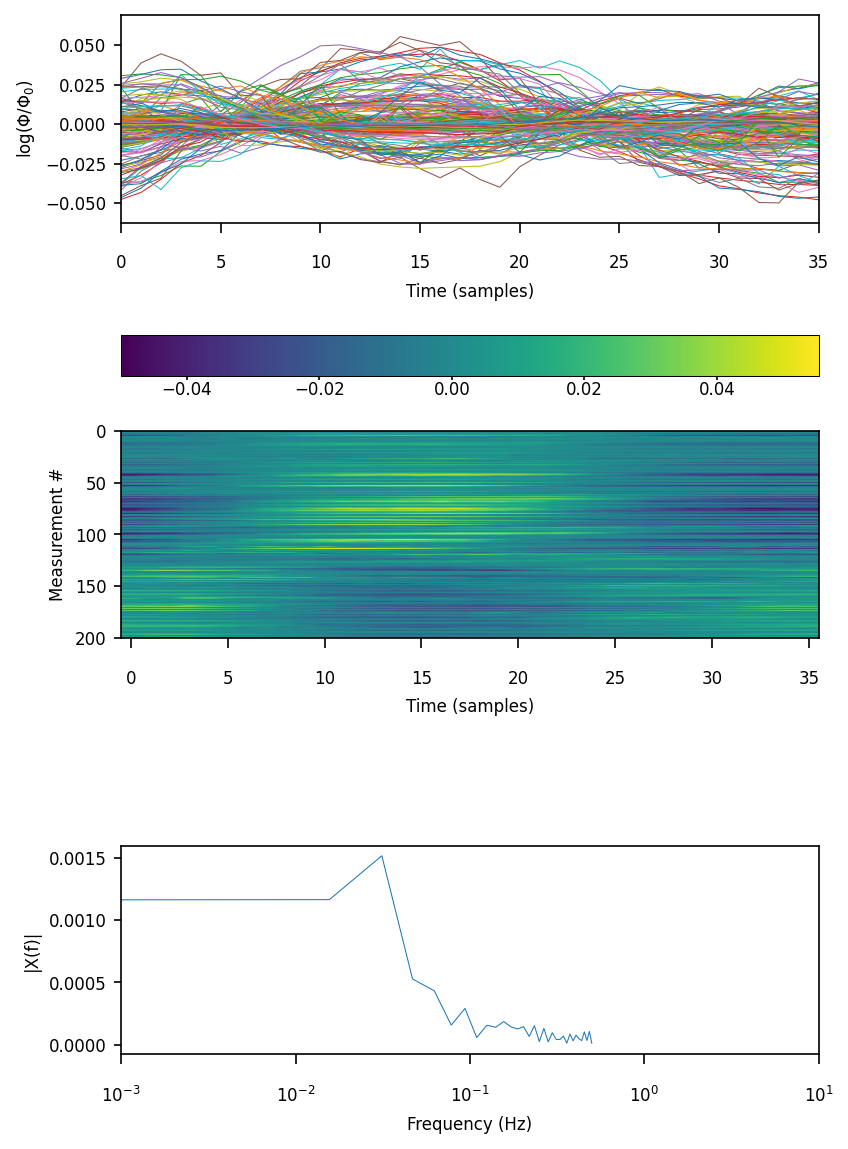

In [18]:
## Block Averaging
synchs = info['paradigm']['Pulse_2']-1
badata,_,_,_ = anlys.BlockAverage(rdata, info['paradigm']['synchpts'][synchs], 36)
keep = np.logical_and(np.logical_and(np.where(info['pairs']['WL'] == 2,1,0), np.where(info['pairs']['r2d'] < 40,1,0)), info['MEAS']['GI']) 

# Generate 3 subplots
fig = plt.figure(dpi = 150, facecolor = 'white')
fig.set_size_inches(6,9)
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(badata[keep,:]), linewidth = 0.5) # plot signals 
ax1.set_xlabel('Time (samples)',labelpad =5)
ax1.set_ylabel('log(\u03A6/$\u03A6_{0}$)') 
ax1.xaxis.set_tick_params(color='black')
ax1.tick_params(axis='x', colors='black', pad = 10, size = 5)
ax1.set_ylim([1.25*np.amin(badata[keep,:]),1.25*np.amax(abs(badata[keep,:]))])
ax1.set_xlim([0, len(badata[keep,:][1])-1])

im2 = ax2.imshow(badata[keep,:], aspect = 'auto')
ax2.set_xlabel('Time (samples)', labelpad = 5)
ax2.set_ylabel('Measurement #') 
ax2.xaxis.set_tick_params(color='black')
ax2.tick_params(axis='x', colors='black', pad = 10, size = 5)
xplot = np.transpose(np.reshape(np.mean(np.transpose(badata[keep,:]),1), (len(np.mean(np.transpose(badata[keep,:]),1)),1)))

axins1 = inset_axes(ax2,
                        width="100%",  
                        height="20%", 
                        loc='upper center',
                        bbox_to_anchor=(0, 0.5, 1, 1),
                        bbox_transform=ax2.transAxes)
        
cb = fig.colorbar(im2, cax=axins1, orientation="horizontal", drawedges=False)
cb.ax.xaxis.set_tick_params(color="black", pad = 0, length = 2)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color="black", fontsize = 8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.5)

ftdomain, ftmag,_,_ = tx4m.fft_tts(xplot,info['system']['framerate']) # Generate average spectrum
ftmag = np.reshape(ftmag, (len(ftdomain)))
ax3.semilogx(ftdomain,ftmag, linewidth = 0.5)                         # plot vs. log frequency
ax3.set_xlabel('Frequency (Hz)', labelpad = 5)
ax3.set_ylabel('|X(f)|') 
ax3.set_xlim([1e-3, 10])
ax3.xaxis.set_tick_params(color='black')
ax3.tick_params(axis='x', colors='black', pad = 10, size = 5)
plt.subplots_adjust(hspace = 1)

(0.0, 35.0)

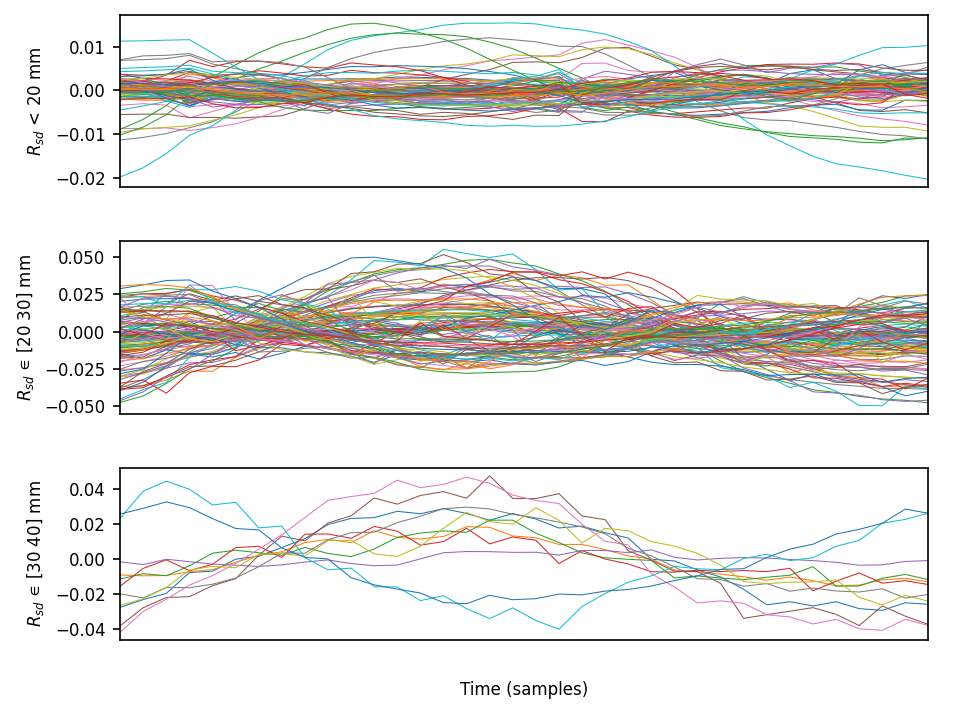

In [19]:
# Visualize Data after Block Averaging at different S-D distances
fig = plt.figure(dpi = 150, tight_layout = True, facecolor='white')
gs = gridspec.GridSpec(3,1)
ax1 =  plt.subplot(gs[0,0])
ax2 =  plt.subplot(gs[1,0])
ax3 =  plt.subplot(gs[2,0])

ax1.plot(np.transpose(badata[keepd1,:]), linewidth = 0.5)
ax1.set_ylabel('$R_{sd}$ < 20 mm')
ax1.set_xlim([0, len(badata[keepd1,:][1])-1])

ax2.plot(np.transpose(badata[keepd2,:]), linewidth = 0.5)
ax2.set_ylabel('$R_{sd}$ \u220A [20 30] mm')
ax2.set_xlim([0, len(badata[keepd2,:][1])-1])

ax3.plot(np.transpose(badata[keepd3,:]), linewidth = 0.5)
ax3.set_ylabel('$R_{sd}$ \u220A [30 40] mm')
ax3.set_xlabel('Time (samples)')
ax3.set_xlim([0, len(badata[keepd3,:][1])-1])